<h2><font color='#FF8C00'>Описание датасета</font></h2>
<strong><font color='#FFA07A'><ins>Home Ownership</ins></font></strong> - домовладение</br>
<strong><font color='#FFA07A'><ins>Annual Income</ins></font></strong> - годовой доход</br>
<strong><font color='#FFA07A'><ins>Years in current job</ins></font></strong> - количество лет на текущем месте работы</br>
<strong><font color='#FFA07A'><ins>Tax Liens</ins></font></strong> - налоговые обременения</br>
<strong><font color='#FFA07A'><ins>Number of Open Accounts</ins></font></strong> - количество открытых счетов</br>
<strong><font color='#FFA07A'><ins>Years of Credit History</ins></font></strong> - количество лет кредитной истории</br>
<strong><font color='#FFA07A'><ins>Maximum Open Credit</ins></font></strong> - наибольший открытый кредит</br>
<strong><font color='#FFA07A'><ins>Number of Credit Problems</ins></font></strong> - количество проблем с кредитом</br>
<strong><font color='#FFA07A'><ins>Months since last delinquent</ins></font></strong> - количество месяцев с последней просрочки платежа</br>
<strong><font color='#FFA07A'><ins>Bankruptcies</ins></font></strong> - банкротства</br>
<strong><font color='#FFA07A'><ins>Purpose</ins></font></strong> - цель кредита</br>
<strong><font color='#FFA07A'><ins>Term</ins></font></strong> - срок кредита</br>
<strong><font color='#FFA07A'><ins>Current Loan Amount</ins></font></strong> - текущая сумма кредита</br>
<strong><font color='#FFA07A'><ins>Current Credit Balance</ins></font></strong> - текущий кредитный баланс</br>
<strong><font color='#FFA07A'><ins>Monthly Debt</ins></font></strong> - ежемесячный долг</br>
<strong><font color='#FFA07A'><ins>Credit Default</ins></font></strong> - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)</br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from random import randint as rd
from sklearn.model_selection import GridSearchCV
import featuretools as ft

In [2]:
train = pd.read_csv(r'course_project_train.csv')
test = pd.read_csv(r'course_project_test.csv')
train.shape, test.shape

((7500, 17), (2500, 16))

In [3]:
train.dtypes, '*'*50,  test.dtypes

(Home Ownership                   object
 Annual Income                   float64
 Years in current job             object
 Tax Liens                       float64
 Number of Open Accounts         float64
 Years of Credit History         float64
 Maximum Open Credit             float64
 Number of Credit Problems       float64
 Months since last delinquent    float64
 Bankruptcies                    float64
 Purpose                          object
 Term                             object
 Current Loan Amount             float64
 Current Credit Balance          float64
 Monthly Debt                    float64
 Credit Score                    float64
 Credit Default                    int64
 dtype: object,
 '**************************************************',
 Home Ownership                   object
 Annual Income                   float64
 Years in current job             object
 Tax Liens                       float64
 Number of Open Accounts         float64
 Years of Credit History   

Видим, что датасет состоит из разных типов данных. В тренировочном наборе присутствует целевая переменная.<br>
Перенесем целевоую переменную Credit Default в отдельный массив.

In [4]:
target = pd.DataFrame(train['Credit Default'])
train = train.drop(['Credit Default'], 1)
train['source'] = 'train'
test['source'] = 'test'

df = pd.concat([train, test])

train.shape, test.shape, target.shape, df.shape

((7500, 17), (2500, 17), (7500, 1), (10000, 17))

In [5]:
df.isna().sum()

Home Ownership                     0
Annual Income                   2070
Years in current job             457
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    5439
Bankruptcies                      17
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    2070
source                             0
dtype: int64

Мы видим, что в датасете есть много пропусков.<br>Посмотрим как можно от них избавиться и взглянем что находится в категориальных значениях:

In [6]:
print('ownership: ', df["Home Ownership"].unique(), '\n\njob_length: ', df['Years in current job'].unique(), '\n\ncredit_purpose: ', df['Purpose'].unique(), '\n\ncredit_term: ', df['Term'].unique())

ownership:  ['Own Home' 'Home Mortgage' 'Rent' 'Have Mortgage'] 

job_length:  [nan '10+ years' '8 years' '6 years' '7 years' '5 years' '1 year'
 '< 1 year' '4 years' '3 years' '2 years' '9 years'] 

credit_purpose:  ['debt consolidation' 'other' 'home improvements' 'take a trip'
 'buy a car' 'small business' 'business loan' 'wedding'
 'educational expenses' 'buy house' 'medical bills' 'moving'
 'major purchase' 'vacation' 'renewable energy'] 

credit_term:  ['Short Term' 'Long Term']


Видно, что большинство признаков очень разнятся в значениях.<br>
Сходу можем преобразовать в дамми только срок кредита. Но лучше заменить фичу на 'Short_term' и расставить значения 1 и 0.<br>
В признаке 'Home Ownership' видим близкие по смыслу значения 'Home Mortgage' и 'Have Mortgage'. Будем считать, что это об одном и том же - жилье в ипотеке.
Преобразуем столбец в более значимый для модели: если жилье свое - человек имеет меньше обязательных платежей. Новый столбец 'Own_House' со значениями 0 и 1 для тех, у кого есть потенциальный залог, а так же столбец 'Extra_Pay' для тех, у кого жилье не в собственности.<br>
Остальные нужно дополнитьельно исследовать.

In [7]:
df['Short_Term'] = df['Term'].apply(lambda x: 1 if x == 'Short Term' else 0)

df['Own_House'] = df['Home Ownership'].apply(lambda x: 1 if x == 'Own Home' else 0)

df['Extra_pay'] = df['Home Ownership'].apply(lambda x: 1 if x in ['Home Mortgage', 'Rent', 'Have Mortgage'] else 0)

df = df.drop(['Term', 'Home Ownership'], 1)

df.tail()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,source,Short_Term,Own_House,Extra_pay
2495,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,99999999.0,162735.0,15046.0,745.0,test,1,0,1
2496,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,468512.0,1439269.0,32996.0,NaN,test,1,0,1
2497,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,430496.0,676438.0,36912.0,695.0,test,1,0,1
2498,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,257774.0,391248.0,13506.0,744.0,test,1,0,1
2499,1694439.0,10+ years,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,763004.0,559531.0,23440.0,6820.0,test,0,0,1


In [8]:
len(df['Years in current job'].unique())

12

Text(0.5, 1.0, 'Borrower experience')

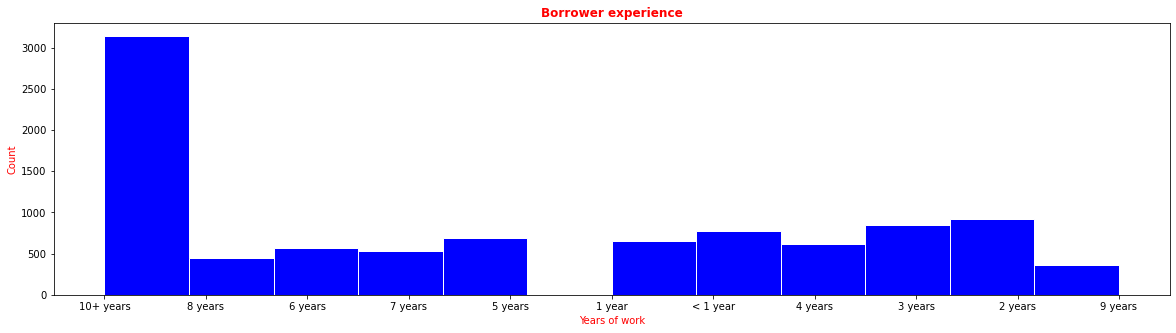

In [9]:
plt.figure(figsize=(20, 5))

df['Years in current job'].hist(bins=12, color='blue', ec='white', grid=False)
plt.ylabel('Count', c='red')
plt.xlabel('Years of work', c='red')
plt.title('Borrower experience', c='red', fontweight='bold')

Видно, что большинство заемщиков имеют стаж работы больше 10 лет.<br>Попробуем заменить значения числами 0-10.

In [10]:
df['Years in current job'] = df['Years in current job'].str.extract(r'(\d+\.\d+|\d+)', expand=False)
df['Years in current job'] = pd.to_numeric(df['Years in current job'])

df['Years in current job'].isna().sum()

457

In [11]:
df.loc[df['Years in current job'].isna(), 'Years in current job'] = 0

df.tail()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,source,Short_Term,Own_House,Extra_pay
2495,1020053.0,10.0,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,99999999.0,162735.0,15046.0,745.0,test,1,0,1
2496,NaN,2.0,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,468512.0,1439269.0,32996.0,NaN,test,1,0,1
2497,1171806.0,2.0,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,430496.0,676438.0,36912.0,695.0,test,1,0,1
2498,723520.0,10.0,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,257774.0,391248.0,13506.0,744.0,test,1,0,1
2499,1694439.0,10.0,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,763004.0,559531.0,23440.0,6820.0,test,0,0,1


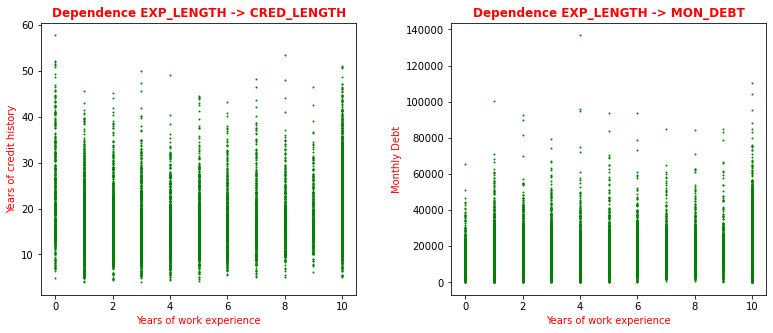

In [12]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plt.scatter(df['Years in current job'], df['Years of Credit History'], c='green', s=1)
plt.xlabel('Years of work experience', c='red')
plt.ylabel('Years of credit history', c='red')
plt.title('Dependence EXP_LENGTH -> CRED_LENGTH', c='red', fontweight='bold')

plt.subplot(122)
plt.scatter(df['Years in current job'], df['Monthly Debt'], c='green', s=1)
plt.xlabel('Years of work experience', c='red')
plt.ylabel('Monthly Debt', c='red')
plt.title('Dependence EXP_LENGTH -> MON_DEBT', c='red', fontweight='bold')

plt.subplots_adjust(wspace=0.3)

В принципе, картина ожидаемая, так как стаж измеряется не общий, а на последнем месте работы.<br>Картина довольно ровная. Не будем ничего менять

Text(0.5, 1.0, 'CREDIT PURPOSE ABSOLUTE')

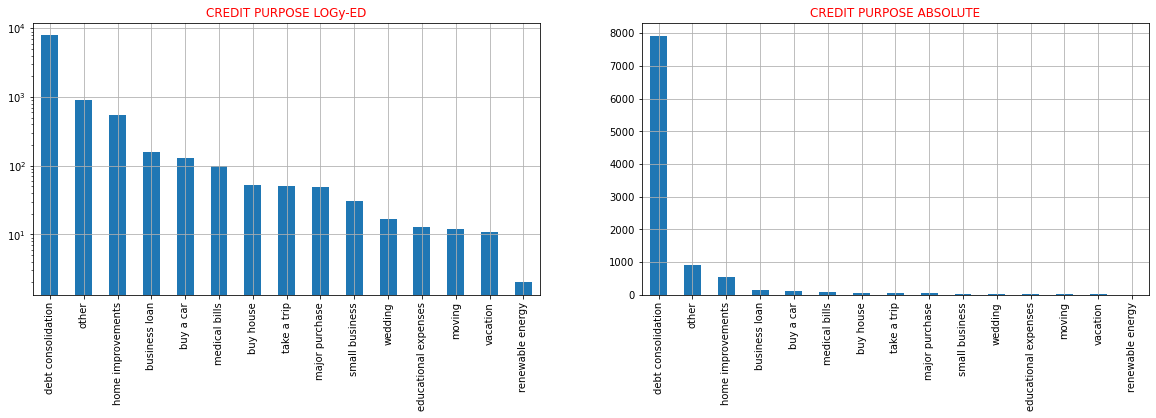

In [13]:
plt.figure(figsize=(20, 5))

plt.subplot(121)
df['Purpose'].value_counts().plot(kind='bar', logy=True, grid=True)
plt.title('CREDIT PURPOSE LOGy-ED', color='red')

plt.subplot(122)
df['Purpose'].value_counts().plot(kind='bar', logy=False, grid=True)
plt.title('CREDIT PURPOSE ABSOLUTE', color='red')

Мы видим, что больше всего кредитов было взято с целью консолидации долгов в одном банке, ремонт дома, для бизнеса, на автомобиль и нецелевые кредиты.<br>
Начнем с самого очевидного - Попробуем применить get_dummies.

In [14]:
df = pd.get_dummies(df, columns=['Purpose'])

train.shape, test.shape, df.shape

((7500, 17), (2500, 17), (10000, 32))

In [15]:
df[5000:5010]

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
5000,1401782.0,4.0,0.0,12.0,7.4,604846.0,0.0,NaN,0.0,405790.0,...,0,0,0,0,0,0,0,0,0,0
5001,815233.0,4.0,0.0,7.0,10.4,352550.0,0.0,NaN,0.0,255090.0,...,0,0,0,0,0,0,0,0,0,0
5002,976068.0,2.0,0.0,5.0,7.3,33242.0,0.0,17.0,0.0,84766.0,...,0,0,0,0,1,0,0,0,0,0
5003,843030.0,10.0,0.0,11.0,10.0,915970.0,0.0,NaN,0.0,216920.0,...,0,0,0,0,0,0,0,0,0,0
5004,946523.0,8.0,0.0,19.0,15.4,432982.0,0.0,15.0,0.0,61446.0,...,0,0,0,0,0,0,0,0,0,0
5005,1862494.0,2.0,0.0,14.0,18.0,368192.0,0.0,NaN,0.0,99999999.0,...,0,0,0,0,1,0,0,0,0,0
5006,938695.0,7.0,0.0,6.0,31.4,110858.0,0.0,44.0,0.0,164120.0,...,0,0,0,0,0,0,0,0,0,0
5007,2795413.0,5.0,0.0,13.0,14.5,1612204.0,0.0,1.0,0.0,273372.0,...,0,0,0,0,0,0,0,0,0,0
5008,1400927.0,9.0,0.0,7.0,16.1,970728.0,0.0,NaN,0.0,562342.0,...,0,0,0,0,0,0,0,0,0,0
5009,2329742.0,2.0,0.0,14.0,26.0,681274.0,0.0,NaN,0.0,333036.0,...,0,0,0,0,1,0,0,0,0,0


In [16]:
df.dtypes

Annual Income                   float64
Years in current job            float64
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
source                           object
Short_Term                        int64
Own_House                         int64
Extra_pay                         int64
Purpose_business loan             uint8
Purpose_buy a car                 uint8
Purpose_buy house                 uint8
Purpose_debt consolidation        uint8
Purpose_educational expenses      uint8
Purpose_home improvements         uint8
Purpose_major purchase            uint8
Purpose_medical bills             uint8


С категориальными фичами разобрались. (source - это наша метка, чтобы не перепутались датасеты train и test).<br>Теперь поработаем с пропусками и поищем выбросы.

In [17]:
df.isna().sum()

Annual Income                   2070
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    5439
Bankruptcies                      17
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    2070
source                             0
Short_Term                         0
Own_House                          0
Extra_pay                          0
Purpose_business loan              0
Purpose_buy a car                  0
Purpose_buy house                  0
Purpose_debt consolidation         0
Purpose_educational expenses       0
Purpose_home improvements          0
Purpose_major purchase             0
Purpose_medical bills              0
Purpose_moving                     0
Purpose_other                      0
P

In [18]:
df.loc[(df['Annual Income'].isna()), ['Tax Liens', 'Years in current job', 'Years of Credit History', 'Bankruptcies', 'Number of Credit Problems', 'Months since last delinquent', 'Current Loan Amount', 'Current Credit Balance']]

,Tax Liens,Years in current job,Years of Credit History,Bankruptcies,Number of Credit Problems,Months since last delinquent,Current Loan Amount,Current Credit Balance
5,0.0,7.0,14.6,0.0,0.0,NaN,337304.0,165680.0
8,0.0,5.0,15.7,1.0,1.0,NaN,129734.0,19.0
9,0.0,1.0,24.6,0.0,0.0,6.0,572880.0,205333.0
10,0.0,1.0,11.5,0.0,0.0,NaN,220858.0,187492.0
16,0.0,7.0,17.8,0.0,0.0,NaN,313038.0,538346.0
...,...,...,...,...,...,...,...,...
2469,0.0,3.0,14.8,0.0,0.0,10.0,267608.0,238697.0
2475,0.0,6.0,13.5,0.0,0.0,81.0,182182.0,149055.0
2479,0.0,3.0,11.6,0.0,0.0,23.0,260458.0,371963.0
2487,0.0,10.0,36.6,0.0,0.0,NaN,455950.0,1255235.0


In [19]:
mean_income = df.loc[(df['Annual Income'] > 0), 'Annual Income'].mean()
df.loc[(df['Annual Income'].isna()), 'Annual Income'] = mean_income
df.head(10)

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,4.820870e+05,0.0,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,99999999.0,...,0,0,0,0,0,0,0,0,0,0
1,1.025487e+06,10.0,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,264968.0,...,0,0,0,0,0,0,0,0,0,0
2,7.514120e+05,8.0,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,99999999.0,...,0,0,0,0,0,0,0,0,0,0
3,8.050680e+05,6.0,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,121396.0,...,0,0,0,0,0,0,0,0,0,0
4,7.762640e+05,8.0,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,125840.0,...,0,0,0,0,0,0,0,0,0,0
5,1.366525e+06,7.0,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,337304.0,...,0,0,0,0,1,0,0,0,0,0
6,1.511108e+06,10.0,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,99999999.0,...,1,0,0,0,0,0,0,0,0,0
7,1.040060e+06,10.0,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,250888.0,...,0,0,0,0,1,0,0,0,0,0
8,1.366525e+06,5.0,0.0,17.0,15.7,0.0,1.0,NaN,1.0,129734.0,...,1,0,0,0,0,0,0,0,0,0
9,1.366525e+06,1.0,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,572880.0,...,0,0,0,0,0,0,0,0,0,0


Решил, что у нас очень мало данных для возможности вычисления примерно истинных значений годового дохода, поэтому нулевые заменим на средние.

In [20]:
df.isna().sum()

Annual Income                      0
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    5439
Bankruptcies                      17
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    2070
source                             0
Short_Term                         0
Own_House                          0
Extra_pay                          0
Purpose_business loan              0
Purpose_buy a car                  0
Purpose_buy house                  0
Purpose_debt consolidation         0
Purpose_educational expenses       0
Purpose_home improvements          0
Purpose_major purchase             0
Purpose_medical bills              0
Purpose_moving                     0
Purpose_other                      0
P

В признаке "Months since last delinquent" нулевые значения скорее всего предполагают отсутствие просрочек. Заменим пропуски нулями.<br> Аналогично и с банкротствами.

In [21]:
df.loc[(df['Months since last delinquent'].isna()), 'Months since last delinquent'] = 0
df.loc[(df['Bankruptcies'].isna()), 'Bankruptcies'] = 0
df.isna().sum()

Annual Income                      0
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent       0
Bankruptcies                       0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    2070
source                             0
Short_Term                         0
Own_House                          0
Extra_pay                          0
Purpose_business loan              0
Purpose_buy a car                  0
Purpose_buy house                  0
Purpose_debt consolidation         0
Purpose_educational expenses       0
Purpose_home improvements          0
Purpose_major purchase             0
Purpose_medical bills              0
Purpose_moving                     0
Purpose_other                      0
P

Для признака 'Credit Score' лучше всего будет обучить регрессор.<br>Для этого мы добавим фичу 'null_cs' чтобы не запутаться на обратном слиянии.<br>Затем обучающий датасет из 7930 значений обучит модель
и предскажем оставшиеся 2070 значений, если метрика r2 будет хорошей.))

In [22]:
# test = df.loc[df['source'] == 'test']
# df = df.query('source != "test"')

# test = test.drop('source', 1)
# df = df.drop('source', 1)

# df['Credit Default'] = target
# test['Credit Default'] = 2

# test.shape, df.shape

In [23]:
# df = pd.concat([df, test])
# df.shape

In [24]:
# df.rename(columns={'Credit Score': 'Credit_Score'}, inplace=True)
# test = df.loc[df['Credit_Score'].isna()]
# df = df.query('Credit_Score != "NaN"')
# test.shape, df.shape, test['Credit_Score'].isna().sum(), df['Credit_Score'].isna().sum()

In [25]:
# test = test.drop('Credit_Score', 1)
# target_cs = df['Credit_Score']
# df = df.drop('Credit_Score', 1)
# test.shape, df.shape

In [26]:
# target_cs.shape

In [27]:
# x_train, x_test, y_train, y_test = train_test_split(df, target_cs, test_size=0.2)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [28]:
# rf = RandomForestRegressor(n_estimators=1000, max_depth=30, max_features=30, max_leaf_nodes=500, random_state=42, n_jobs=-1)
# rf.fit(x_train, y_train)

# rf_pred = rf.predict(x_train)
# rf_real_pred = rf.predict(x_test)

# print(f'R_2 on train: {r2_score(y_train, rf_pred)}\nR_2 on test: {r2_score(y_test, rf_real_pred)}')

In [29]:
# rf = RandomForestRegressor(random_state=42, n_jobs=-1)
# parametrs = {'n_estimators': range(500, 2501, 500),
#              'max_depth': range(9, 31, 3),
#              'max_features': range(9, 31, 3),
#              'max_leaf_nodes': range(20, 201, 10)}

In [30]:
# grid = GridSearchCV(rf, parametrs, cv=5)
# grid.fit(x_train, y_train)
# grid.best_params_

{'max_depth': 9, 'max_features': 12, 'max_leaf_nodes': 40, 'n_estimators': 500}


In [31]:
# rf = RandomForestRegressor(n_estimators=500, max_depth=9, max_features=12, max_leaf_nodes=40, random_state=42, n_jobs=-1)
# rf.fit(x_train, y_train)

# rf_pred = rf.predict(x_train)
# rf_real_pred = rf.predict(x_test)

# print(f'R_2 on train: {r2_score(y_train, rf_pred)}\nR_2 on test: {r2_score(y_test, rf_real_pred)}')

In [32]:
# feature_importance = pd.DataFrame({'name': x_train.columns, 
#                                    'feature_importance': rf.feature_importances_}, 
#                                   columns=['feature_importance', 'name'])
# feature_importance.sort_values(['feature_importance'], ascending=False).reset_index(drop=True)

In [33]:
# cols_to_drop = list(feature_importance.loc[feature_importance['feature_importance'] > 0.02, 'name'])
# cols_to_drop

In [34]:
# df2 = df.drop(cols_to_drop, 1)
# df2.columns

In [35]:
# test = test.drop(cols_to_drop, 1)
# test.columns

In [36]:
# x_train, x_test, y_train, y_test = train_test_split(df2, target_cs, test_size=0.2)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [37]:
# rf = RandomForestRegressor(n_estimators=500, max_depth=10, max_features=10, random_state=42, n_jobs=-1)
# rf.fit(x_train, y_train)

# rf_pred = rf.predict(x_train)
# rf_real_pred = rf.predict(x_test)

# print(f'R_2 on train: {r2_score(y_train, rf_pred)}\nR_2 on test: {r2_score(y_test, rf_real_pred)}')

In [38]:
# feature_importance = pd.DataFrame({'name': x_train.columns, 
#                                    'feature_importance': rf.feature_importances_}, 
#                                   columns=['feature_importance', 'name'])
# feature_importance.sort_values(['feature_importance'], ascending=False).reset_index(drop=True)

In [39]:
# df2.describe()

In [40]:
# df2['Credit Score'] = target_cs
# df2

In [41]:
# gp = df2.groupby(['Credit Default'])['Credit Score'].mean()
# gp

In [42]:
# test.head()

In [43]:
# df2['cd_mean_cs'] = df2['Credit Default'].map(gp.to_dict())
# df2 = df2.drop('Credit Score', 1)

# test['cd_mean_cs'] = test['Credit Default'].map(gp.to_dict())


In [44]:
# test.head()

In [45]:
# x_train, x_test, y_train, y_test = train_test_split(df, target_cs, test_size=0.2)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [46]:
# rf = RandomForestRegressor(n_estimators=50000, max_depth=25, max_features=25, random_state=42, n_jobs=-1)
# rf.fit(x_train, y_train)

# rf_pred = rf.predict(x_train)
# rf_real_pred = rf.predict(x_test)

# print(f'R_2 on train: {r2_score(y_train, rf_pred)}\nR_2 on test: {r2_score(y_test, rf_real_pred)}')

Не получается достигнуть адекватных значений метрики r_2. Попробуем просто заполнить имеющиеся пропуски.


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 2499
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 10000 non-null  float64
 1   Years in current job          10000 non-null  float64
 2   Tax Liens                     10000 non-null  float64
 3   Number of Open Accounts       10000 non-null  float64
 4   Years of Credit History       10000 non-null  float64
 5   Maximum Open Credit           10000 non-null  float64
 6   Number of Credit Problems     10000 non-null  float64
 7   Months since last delinquent  10000 non-null  float64
 8   Bankruptcies                  10000 non-null  float64
 9   Current Loan Amount           10000 non-null  float64
 10  Current Credit Balance        10000 non-null  float64
 11  Monthly Debt                  10000 non-null  float64
 12  Credit Score                  7930 non-null   float64
 13  so

In [48]:
df.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
count,1.000000e+04,10000.00000,10000.000000,10000.00000,10000.000000,1.000000e+04,10000.00000,10000.000000,10000.000000,1.000000e+04,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,1.366525e+06,5.70540,0.031400,11.14430,18.319580,8.865079e+05,0.16800,15.764900,0.114400,1.194381e+07,...,0.055200,0.004900,0.009800,0.001200,0.090500,0.000200,0.003100,0.005100,0.00110,0.001700
std,7.692332e+05,3.64087,0.304341,4.89476,7.095357,1.389982e+07,0.51459,22.640209,0.349464,3.200878e+07,...,0.228382,0.069832,0.098514,0.034622,0.286911,0.014141,0.055594,0.071236,0.03315,0.041198
min,1.065330e+05,0.00000,0.000000,1.00000,3.900000,0.000000e+00,0.00000,0.000000,0.000000,1.124200e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,9.328525e+05,2.00000,0.000000,8.00000,13.500000,2.788115e+05,0.00000,0.000000,0.000000,1.805485e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,1.366525e+06,6.00000,0.000000,10.00000,17.000000,4.781810e+05,0.00000,0.000000,0.000000,3.117180e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,1.498297e+06,10.00000,0.000000,14.00000,22.000000,7.943595e+05,0.00000,29.000000,0.000000,5.210700e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,1.497561e+07,10.00000,15.000000,48.00000,57.700000,1.304726e+09,15.00000,118.000000,5.000000,1.000000e+08,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [49]:
df['Number of Credit Problems'].value_counts()

0.0     8646
1.0     1162
2.0      122
3.0       42
5.0       11
4.0       10
6.0        4
7.0        2
15.0       1
Name: Number of Credit Problems, dtype: int64

In [50]:
df['Credit Score'].value_counts()

740.0     219
747.0     217
741.0     205
748.0     201
745.0     201
         ... 
6710.0      1
6600.0      1
6680.0      1
620.0       1
6110.0      1
Name: Credit Score, Length: 278, dtype: int64

In [51]:
problems_to_credit_score = pd.DataFrame(df.groupby(['Number of Credit Problems'])['Credit Score'].mean())
problems_to_credit_score

,Credit Score
Number of Credit Problems,
0.0,1179.915975
1.0,1090.929825
2.0,1361.121212
3.0,1148.482759
4.0,1587.000000
5.0,1363.222222
6.0,721.250000
7.0,710.500000
15.0,746.000000


In [52]:
a1 = df.loc[df['Credit Score'].isna(), ['Credit Score', 'Number of Credit Problems']]
a1 = a1.apply(lambda x, columns: pd.Series([problems_to_credit_score['Credit Score'][x['Number of Credit Problems']], x['Number of Credit Problems']], index=columns), axis=1, result_type='expand', columns=a1.columns)
df.loc[df['Credit Score'].isna(), ['Credit Score', 'Number of Credit Problems']] = a1

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 2499
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 10000 non-null  float64
 1   Years in current job          10000 non-null  float64
 2   Tax Liens                     10000 non-null  float64
 3   Number of Open Accounts       10000 non-null  float64
 4   Years of Credit History       10000 non-null  float64
 5   Maximum Open Credit           10000 non-null  float64
 6   Number of Credit Problems     10000 non-null  float64
 7   Months since last delinquent  10000 non-null  float64
 8   Bankruptcies                  10000 non-null  float64
 9   Current Loan Amount           10000 non-null  float64
 10  Current Credit Balance        10000 non-null  float64
 11  Monthly Debt                  10000 non-null  float64
 12  Credit Score                  10000 non-null  float64
 13  so

In [54]:
train = df.loc[df['source'] == 'train']
test = df.loc[df['source'] == 'test']

train = train.drop('source', 1)
test = test.drop('source', 1)

train.shape, test.shape

((7500, 31), (2500, 31))

In [55]:
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.3)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5250, 31), (5250, 1), (2250, 31), (2250, 1))

In [56]:
rfc = RandomForestClassifier(n_estimators=500, max_depth=15, max_features=16, max_leaf_nodes=30, random_state=42, n_jobs=-1)
rfc.fit(x_train, np.ravel(y_train))

rf_pred = rfc.predict(x_train)
rf_real_pred = rfc.predict(x_test)

print(f'F1 on train: {f1_score(y_train, rf_pred)}\nF1 on test: {f1_score(y_test, rf_real_pred)}')

F1 on train: 0.47786720321931586
F1 on test: 0.3865546218487395


In [57]:
pd.Series(rf_real_pred).value_counts()

0    2056
1     194
dtype: int64

In [58]:
parameters = [{'n_estimators': [250, 500, 1000],
               'max_depth': np.arange(5, 31, 5),
               'max_features': np.arange(5, 31, 5)}]

In [59]:
rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                  param_grid=parameters,
                  scoring='f1',
                  cv=5)

In [60]:
# rfc.fit(x_train, np.ravel(y_train))

In [61]:
# rfc.best_params_

{'max_depth': 20, 'max_features': 30, 'n_estimators': 500}


In [62]:
pd.DataFrame({'train': y_train.value_counts(), 'test': y_test.value_counts()}, columns=['train', 'test'])

,train,test
Credit Default,,
0,3776,1611
1,1474,639


In [63]:
print(3766 / 1484, 1621 / 629)

2.5377358490566038 2.577106518282989


In [64]:
rfc = RandomForestClassifier(n_estimators=500, max_depth=20, max_features=30, max_leaf_nodes=30, class_weight={0:1, 1:2.55},
                             random_state=42, n_jobs=-1)
rfc.fit(x_train, np.ravel(y_train))

rf_pred = rfc.predict(x_train)
rf_real_pred = rfc.predict(x_test)

print(f'F1 on train: {f1_score(y_train, rf_pred)}\nF1 on test: {f1_score(y_test, rf_real_pred)}')

F1 on train: 0.6296296296296297
F1 on test: 0.533846153846154


Хорошо, что нету переобучения, но результаты меня не устраивают.

In [65]:
from imblearn.over_sampling import SMOTE

In [79]:
smote = SMOTE()
x_train_balanced_over, y_train_balanced_over = smote.fit_resample(x_train, y_train)

y_train_balanced_over.value_counts()

Credit Default
1                 3776
0                 3776
dtype: int64

In [105]:
rfc = RandomForestClassifier(n_estimators=500, max_depth=15, max_features=10, max_leaf_nodes=30, 
                             random_state=42, n_jobs=-1)
rfc.fit(x_train_balanced_over, np.ravel(y_train_balanced_over))

rf_pred_over = rfc.predict(x_train)
rf_real_pred_over = rfc.predict(x_test)

print(f'OVERSAMPLING:\non train: {f1_score(y_train, rf_pred_over)}\nF1 on test: {f1_score(y_test, rf_real_pred_over)}')

OVERSAMPLING:
on train: 0.5462522851919561
F1 on test: 0.5117085862966174


In [68]:
from imblearn.under_sampling import TomekLinks

In [84]:
tl = TomekLinks()
x_train_balanced_under, y_train_balanced_under = tl.fit_resample(x_train, y_train)

y_train_balanced_under.value_counts()

Credit Default
0                 3220
1                 1474
dtype: int64

In [85]:
rfc = RandomForestClassifier(n_estimators=500, max_depth=15, max_features=10, max_leaf_nodes=30, 
                             random_state=42, n_jobs=-1)
rfc.fit(x_train_balanced_under, np.ravel(y_train_balanced_under))

rf_pred_under = rfc.predict(x_train)
rf_real_pred_under = rfc.predict(x_test)

print(f'UNDERSAMPLING:\nF1 on train: {f1_score(y_train, rf_pred_under)}\nF1 on test: {f1_score(y_test, rf_real_pred_under)}')

UNDERSAMPLING:
F1 on train: 0.5265133740028155
F1 on test: 0.4412094064949608


In [112]:
# parameters = [{'n_estimators': [500],
#                'max_depth': np.arange(3, 32, 7),
#                'max_features': np.arange(3, 32, 7),
#                'max_leaf_nodes': np.arange(30, 106, 15)}]

# rfc_gs = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
#                   param_grid=parameters,
#                   scoring='f1',
#                   cv=5)

# rfc_gs.fit(x_train_balanced_over, np.ravel(y_train_balanced_over))

# rfc_gs.best_params_

{'max_depth': 31,
 'max_features': 10,
 'max_leaf_nodes': 105,
 'n_estimators': 500}

{'max_depth': 31,
 'max_features': 10,
 'max_leaf_nodes': 105,
 'n_estimators': 500}

In [122]:
rfc = RandomForestClassifier(n_estimators=500, max_depth=15, max_features=20, max_leaf_nodes=45, 
                             random_state=42, n_jobs=-1)
rfc.fit(x_train_balanced_over, np.ravel(y_train_balanced_over))

rf_pred_over = rfc.predict(x_train)
rf_real_pred_over = rfc.predict(x_test)

print(f'with OVERSAMPLING:\non train: {f1_score(y_train, rf_pred_over)}\nF1 on test: {f1_score(y_test, rf_real_pred_over)}')

with OVERSAMPLING:
on train: 0.5820456217807212
F1 on test: 0.518843120070114


Попробуем другие модели.

In [123]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [124]:
scaler = StandardScaler()
lr = LogisticRegression()

In [126]:
source = df['source']
df = df.drop('source', 1)

In [134]:
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled['source'] = source.values
df_scaled.tail()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,...,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,source
9995,-0.450434,1.179612,-0.103179,0.583449,1.519439,-0.023552,1.616903,2.307298,2.534296,2.751139,...,-0.070172,-0.099484,-0.034662,-0.315444,-0.014144,-0.055764,-0.071597,-0.033185,-0.041266,test
9996,0.000000,-1.017775,-0.103179,0.787759,-0.185987,0.061246,-0.326490,2.704841,-0.327375,-0.358523,...,-0.070172,-0.099484,-0.034662,-0.315444,-0.014144,-0.055764,-0.071597,-0.033185,-0.041266,test
9997,-0.253146,-1.017775,-0.103179,7.530000,-0.777953,0.058991,-0.326490,-0.696358,-0.327375,-0.359710,...,-0.070172,-0.099484,-0.034662,-0.315444,-0.014144,-0.055764,-0.071597,-0.033185,-0.041266,test
9998,-0.835945,1.179612,-0.103179,0.583449,1.477155,0.004264,-0.326490,-0.696358,-0.327375,-0.365107,...,-0.070172,-0.099484,-0.034662,-0.315444,-0.014144,-0.055764,-0.071597,-0.033185,-0.041266,test
9999,0.426309,1.179612,-0.103179,0.174828,0.011335,0.022537,1.616903,2.483984,-0.327375,-0.349322,...,-0.070172,-0.099484,-0.034662,-0.315444,-0.014144,-0.055764,-0.071597,-0.033185,-0.041266,test


In [135]:
train = pd.DataFrame(df_scaled.loc[df_scaled['source'] == 'train'])
test = pd.DataFrame(df_scaled.loc[df_scaled['source'] == 'test'])

train = train.drop('source', 1)
test = test.drop('source', 1)

In [140]:
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.3)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5250, 31), (5250, 1), (2250, 31), (2250, 1))

In [141]:
lr.fit(x_train, np.ravel(y_train))

lr_pred_train = lr.predict(x_train)
lr_pred_test = lr.predict(x_test)

print(f'LOG REGRESSION:\non train: {f1_score(y_train, lr_pred_train)}\nF1 on test: {f1_score(y_test, lr_pred_test)}')

LOG REGRESSION:
on train: 0.41730279898218825
F1 on test: 0.3899657924743444


In [142]:
smote = SMOTE()
x_train_balanced_over_lr, y_train_balanced_over_lr = smote.fit_resample(x_train, y_train)

y_train_balanced_over.value_counts()

Credit Default
1                 3776
0                 3776
dtype: int64

In [145]:
lr.fit(x_train_balanced_over_lr, np.ravel(y_train_balanced_over_lr))

lr_pred_train = lr.predict(x_train)
lr_pred_test = lr.predict(x_test)

print(f'LOG REGRESSION:\nF1 on train: {f1_score(y_train, lr_pred_train)}\nF1 on test: {f1_score(y_test, lr_pred_test)}')

LOG REGRESSION:
F1 on train: 0.53510093401627
F1 on test: 0.5178082191780823


In [146]:
from sklearn.neighbors import KNeighborsClassifier

In [147]:
knc = KNeighborsClassifier()

In [150]:
knc.fit(x_train, np.ravel(y_train))

knc_pred_train = knc.predict(x_train)
knc_pred_test = knc.predict(x_test)

print(f'KNeighborsC REGRESSION:\nF1 on train: {f1_score(y_train, knc_pred_train)}\nF1 on test: {f1_score(y_test, knc_pred_test)}')

KNeighborsC REGRESSION:
F1 on train: 0.5972396486825595
F1 on test: 0.40847784200385356


In [151]:
knc.fit(x_train_balanced_over_lr, np.ravel(y_train_balanced_over_lr))

lr_pred_train = knc.predict(x_train)
lr_pred_test = knc.predict(x_test)

print(f'KNeighborsC REGRESSION:\nF1 on train: {f1_score(y_train, lr_pred_train)}\nF1 on test: {f1_score(y_test, lr_pred_test)}')

KNeighborsC REGRESSION:
F1 on train: 0.7018311013938233
F1 on test: 0.46766169154228854


In [155]:
import xgboost as xgb

In [163]:
xgbc = xgb.XGBClassifier(random_state=42, n_estimators=100)
xgbc.fit(x_train, np.ravel(y_train))

xgbc_pred_train = xgbc.predict(x_train)
xgbc_pred_test = xgbc.predict(x_test)

print(f'XBoost:\nF1 on train: {f1_score(y_train, xgbc_pred_train)}\nF1 on test: {f1_score(y_test, xgbc_pred_test)}')

C:\Users\EssenceD\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:52:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XBoost:
F1 on train: 0.9329934450109248
F1 on test: 0.44003777148253065


In [165]:
x_train_balanced_under, y_train_balanced_under = tl.fit_resample(x_train, y_train)

x_train_balanced_under_over, y_train_balanced_under_over = smote.fit_resample(x_train_balanced_under, y_train_balanced_under)

y_train_balanced_under.value_counts()

Credit Default
0                 3437
1                 1457
dtype: int64

In [166]:
xgbc.fit(x_train_balanced_under_over, np.ravel(y_train_balanced_under_over))

xgbc_pred_train = xgbc.predict(x_train)
xgbc_pred_test = xgbc.predict(x_test)

print(f'XBoost:\nF1 on train: {f1_score(y_train, xgbc_pred_train)}\nF1 on test: {f1_score(y_test, xgbc_pred_test)}')

C:\Users\EssenceD\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XBoost:
F1 on train: 0.9218696690549301
F1 on test: 0.4751020408163265


In [175]:
import lightgbm as lgbm
lgbmc = lgbm.LGBMClassifier(random_state=42, class_weight={0:1, 1:2.55})

In [176]:
lgbmc.fit(x_train, np.ravel(y_train))

lgbmc_pred_train = lgbmc.predict(x_train)
lgbmc_pred_test = lgbmc.predict(x_test)

print(f'LGBMC model:\nF1 on train: {f1_score(y_train, lgbmc_pred_train)}\nF1 on test: {f1_score(y_test, lgbmc_pred_test)}')

LGBMC model:
F1 on train: 0.8877518388231532
F1 on test: 0.5092798812175204


In [172]:
lgbmc = lgbm.LGBMClassifier(random_state=42)
lgbmc.fit(x_train_balanced_under_over, np.ravel(y_train_balanced_under_over))

lgbmc_pred_train = lgbmc.predict(x_train)
lgbmc_pred_test = lgbmc.predict(x_test)

print(f'LGBMC model balanced:\nF1 on train: {f1_score(y_train, lgbmc_pred_train)}\nF1 on test: {f1_score(y_test, lgbmc_pred_test)}')

LGBMC model balanced:
F1 on train: 0.8207513416815742
F1 on test: 0.4967532467532468


In [184]:
df.columns

Index(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Short_Term',
       'Own_House', 'Extra_pay', 'Purpose_business loan', 'Purpose_buy a car',
       'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational expenses', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
       'Purpose_other', 'Purpose_renewable energy', 'Purpose_small business',
       'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding'],
      dtype='object')

In [186]:
cat_df = df_scaled[df_scaled.columns.drop(list(df_scaled.filter(regex='Purpose')))]
cat_df.columns

Index(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Short_Term',
       'Own_House', 'Extra_pay', 'source'],
      dtype='object')

In [188]:
cat_train = cat_df.loc[cat_df['source'] == 'train']
cat_test = cat_df.loc[cat_df['source'] == 'test']

cat_train = cat_train.drop('source', 1)
cat_test = cat_test.drop('source', 1)

In [191]:
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(cat_train, target, test_size=0.3)
x_train_cat.shape, y_train_cat.shape, x_test_cat.shape, y_test_cat.shape

((5250, 16), (5250, 1), (2250, 16), (2250, 1))

In [195]:
import catboost as cb
cbc = cb.CatBoostClassifier(silent=True, random_state=42, class_weights=[1, 2.55]) 

cbc.fit(x_train_cat, np.ravel(y_train_cat))
cbc_pred_train = cbc.predict(x_train_cat)
cbc_pred_test = cbc.predict(x_test_cat)

print(f'CatBoostModel:\nF1 on train: {f1_score(y_train_cat, cbc_pred_train)}\nF1 on test: {f1_score(y_test_cat, cbc_pred_test)}')

CatBoostModel:
F1 on train: 0.8320363164721142
F1 on test: 0.5317577548005908


In [196]:
x_train_balanced_under_cat, y_train_balanced_under_cat = tl.fit_resample(x_train_cat, y_train_cat)

x_train_balanced_under_over_cat, y_train_balanced_under_over_cat = smote.fit_resample(x_train_balanced_under_cat, y_train_balanced_under_cat)

y_train_balanced_under_cat.value_counts()

Credit Default
0                 3422
1                 1447
dtype: int64

In [197]:
cbc.fit(x_train_balanced_under_over_cat, np.ravel(y_train_balanced_under_over_cat))
cbc_pred_train = cbc.predict(x_train)
cbc_pred_test = cbc.predict(x_test)

print(f'CatBoostModel balanced:\nF1 on train: {f1_score(y_train, cbc_pred_train)}\nF1 on test: {f1_score(y_test, cbc_pred_test)}')

CatBoostModel balanced:
F1 on train: 0.6539999999999999
F1 on test: 0.6636517806670436


план: доавить признак по цели кредита. разбить на 1 и 0